# **Toxic Comment Classification Challenge**

### **1. Descripção do problema**

 Em várias plataformas de mídia social, as seçães de comentários permitem que os usuários
 compartilhem ideias e discutam diferentes pontos de vista. No entanto, há um abuso
 de linguagem tóxica, especialmente no X (antigo Twitter), que não tem regras rígidas
 para regular esse tipo de comentário, o que está afetando a qualidade dessas conversas.
 Comentários que incluem ameaças, insultos, linguagem vulgar ou ódio contra certos gru
 pos sociais, dificultando um diálogo saudável.

### **Fase 1: Análise e Pré-processamento**

### **2. Análise descritiva de cada atributo**

### **Importação de biblioteca e carregamento de dados**

In [59]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from textstat import flesch_reading_ease
import warnings
warnings.filterwarnings("ignore")

# Carregando os dados
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [60]:
import re

def contar_palabras_validas(text):
    if not isinstance(text, str):
        return 0
    # Solo letras, minúsculas, al menos 2 letras
    palabras = re.findall(r'\b[a-z]{2,}\b', text.lower())
    return len(palabras)



In [61]:

# Adicionar a coluna length (número de palavras no comentário)
train['length'] = train['comment_text'].apply(contar_palabras_validas)

# Adicionar a coluna flesch_scaler (índice de legibilidade)
train['flesch_score'] = train['comment_text'].apply(lambda x: flesch_reading_ease(str(x)))

# Adicionar a coluna length (número de palavras no comentário)
test['length'] = test['comment_text'].apply(contar_palabras_validas)

# Adicionar a coluna flesch_scaler (índice de legibilidade)
test['flesch_score'] = test['comment_text'].apply(lambda x: flesch_reading_ease(str(x)))
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,flesch_score
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,41,66.370388
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,13,73.795735
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,41,65.725000
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,102,51.112030
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,89.606731


#### **a) Identificar os tipos de atributos**

A identificação dos tipos de atributos consiste em classificar cada coluna do dataset conforme sua natureza: **nominal**, **ordinal**, **binário**, **contínuo** ou **discreto**.

<center>

| Coluna | Tipo de Atributo | Descrição |
|-----------|-----------|---------------|
| id | Categórico nominai | Identificador único. <br>Não tem ordem nem significado além de identificar a fila |
| comment_text | Categórico nominai | Texto livre que contém o comentário a classificar.<br>Não team hierarquia nem ordem |
| toxic <br> severe_toxic <br> obscene <br> threat <br> insult<br> identity_hate| Binário assimétrico | 1 = Tóxico, 0 = Não Tóxico. <br> A classe positiva (1) é menos frequente, pelo que é assimétrica |
| length         | Contínuo             | Número total de palavras no comentário.                                |
| flesch_scaler  | Contínuo             | Índice de legibilidade Flesch Reading Ease. Valores mais altos indicam maior facilidade de leitura. |


</center>

- **`id`** e **`comment_text`** são **atributos nominais**, não usados diretamente na modelagem.
- As etiquetas (**`toxic`**, **`severe_toxic`**, **`obscene`**, **`threat`**, **`insult`**, **`identity_hate`**.) são **binárias assimétricas**, importantes para prever comportamentos tóxicos.

Além das variáveis fornecidas no dataset original, foram adicionados dois novos atributos numéricos:

- **`length`**: representa o número de palavras no comentário.
- **`flesch_scaler`**: mede a legibilidade do comentário com base no índice Flesch Reading Ease. Comentários mais simples tendem a ter pontuações mais altas.

#### **b) Para atributo numérico: análise descritiva e visualização**

Nesta etapa, devemos identificar para cada atributo numérico e não categorizado:

- Intervalo de valores (mínimo e máximo).

- Valor médio.

- Desvio-padrão.

- Possíveis valores aberrantes (outliers).


              length   flesch_score
count  159571.000000  159571.000000
mean       63.638907      60.118723
std        94.741037     128.131875
min         0.000000  -36681.810000
25%        15.000000      49.484853
50%        33.000000      63.176029
75%        71.000000      76.553333
max      1354.000000     134.080000


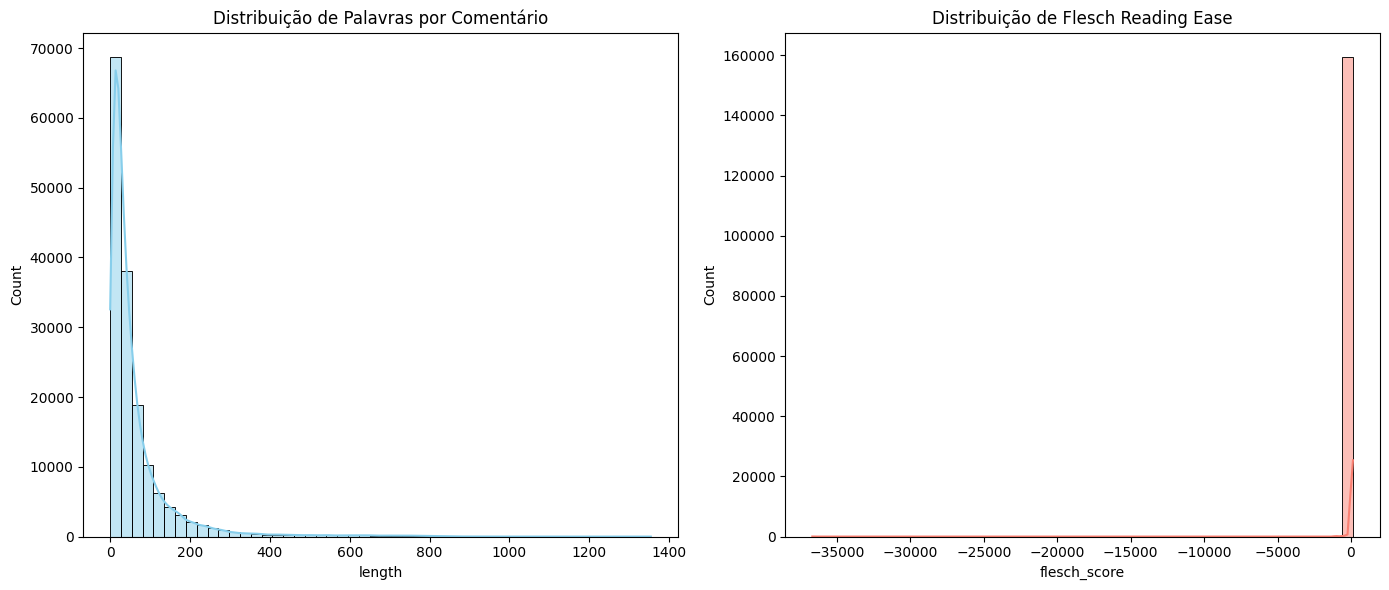

In [62]:
# Estatísticas descritivas
print(train[['length', 'flesch_score']].describe())

# Histograma
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train['length'], bins=50, kde=True, color='skyblue')
plt.title('Distribuição de Palavras por Comentário')

plt.subplot(1, 2, 2)
sns.histplot(train['flesch_score'], bins=50, kde=True, color='salmon')
plt.title('Distribuição de Flesch Reading Ease')

plt.tight_layout()
plt.show()

**Lenght**
- A maioria dos comentários possui uma quantidad menor que 200 palavras.
- A distribuição é assimétrica à direita (distribuição enviesada positivamente), com poucos comentários extremamente longos (outliers).
- Esse padrão é típico em dados de texto, pois a maioria dos comentários tende a ser breve.

**Flesch Reading Ease**
- A maioria dos valores está concentrada em torno de 0, com valores negativos extremos que indicam baixa legibilidade.
- Valores tão negativos sugerem possíveis erros na extração dos textos (ex: strings vazias ou mal formatadas).

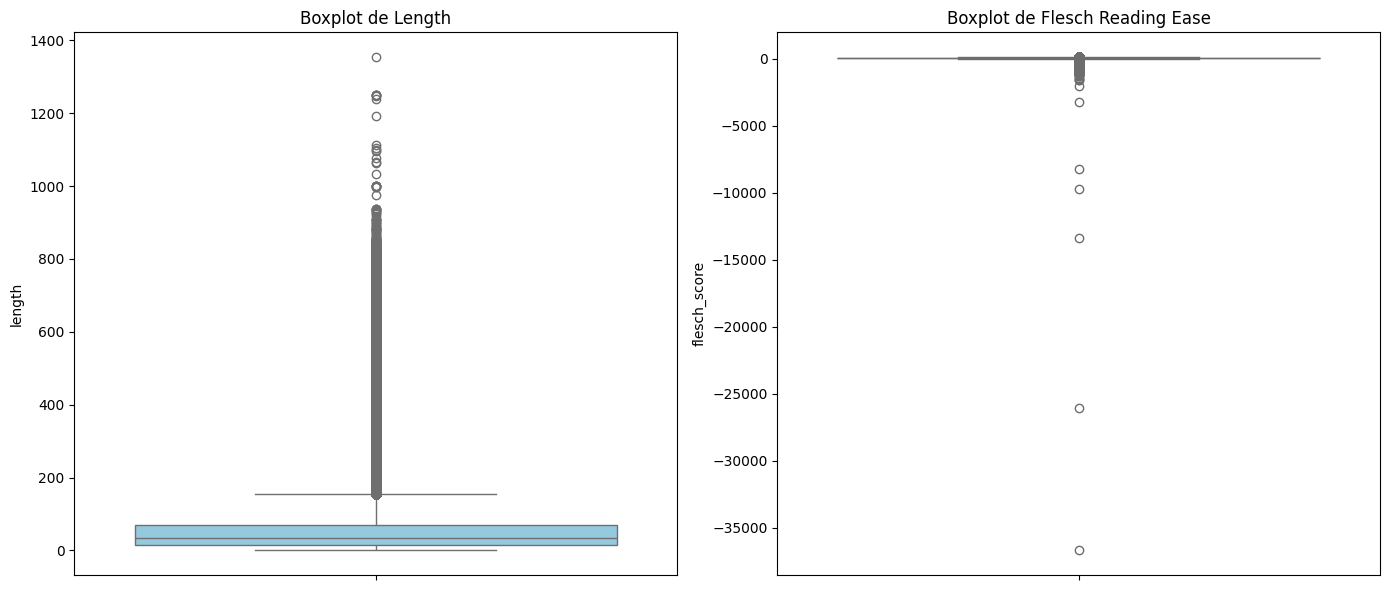

In [63]:
# Boxplots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=train['length'], color='skyblue')
plt.title('Boxplot de Length')

plt.subplot(1, 2, 2)
sns.boxplot(y=train['flesch_score'], color='salmon')
plt.title('Boxplot de Flesch Reading Ease')

plt.tight_layout()
plt.show()

**Lenght**
- A mediana é visivelmente baixa, confirmando que a maioria dos comentários sao curtos.
- Existem vários **outliers** com comprimento significativamente maior que o terceiro quartil, sugerindo a necessidade de tratamento dependendo do modelo usado.

**Flesch Reading Ease**
- Há uma grande quantidade de outliers muito abaixo de 0, reforçando a suspeita de dados problemáticos.
- A dispersão é alta, o que indica que os comentários possuem uma variabilidade significativa em termos de facilidade de leitura.

### **c) Distribuição de valores e popularidade dos atributos**

Nesta etapa, para cada atributo **binário, nominal ou ordinal**, devemos:

- Identificar os **valores possíveis**.  
- Verificar a **popularidade** ou **frequência relativa** de cada valor (distribuição de probabilidade).

No nosso dataset, analisamos as **etiquetas binárias**: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult` e `identity_hate`.  
Para o atributo `comment_text` (nominal), não é viável analisar distribuição direta, mas podemos analisar o **comprimento** ou outras métricas.


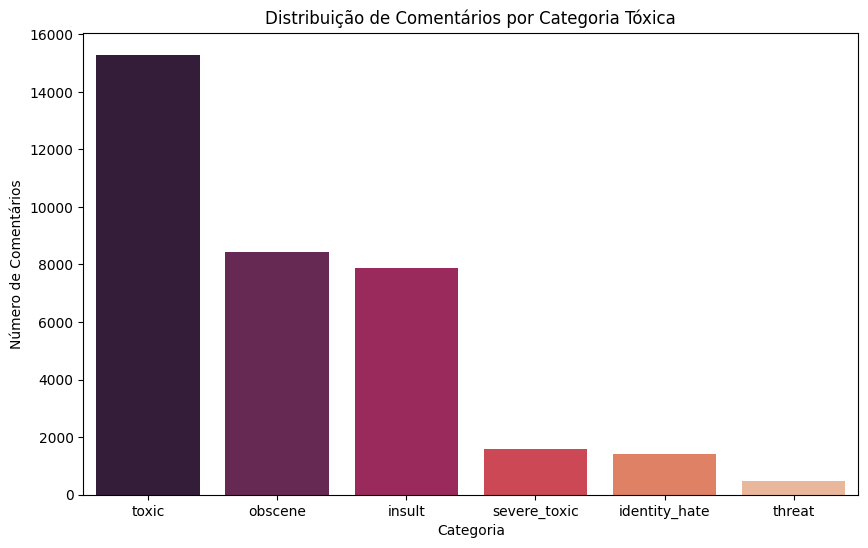

In [64]:
# Lista de columnas de etiquetas
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Conteo absoluto por etiqueta
label_counts = train[toxic_labels].sum().sort_values(ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="rocket")
plt.title('Distribuição de Comentários por Categoria Tóxica')
plt.ylabel('Número de Comentários')
plt.xlabel('Categoria')
plt.show()


Classe **"toxic"**:

- É de longe a mais frequente (~15.000 ocorrências).

- Isso sugere que se trata de um rótulo genérico que agrupa várias formas de toxicidade.

Classe **"Obscene"** e **"insult"**:

- São as segundas mais comuns (~8.000 e ~7.000 ocorrências, respectivamente).

- Indicam que insultos e linguagem obscena são frequentes no conjunto.

Classe **"severe_toxic"**, **"identity_hate"** e **"threat"**:

- São claramente sub-representadas, especialmente "threat" e "identity_hate", que apresentam pouquíssimas ocorrências (~1.000 ou menos).

- Isso introduz um problema de desequilíbrio de classes, que pode afetar o desempenho do modelo se não for tratado adequadamente.

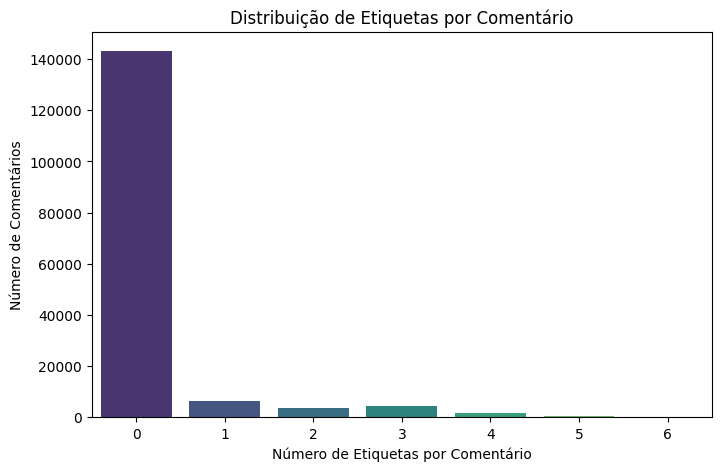

In [65]:
# Adicionar a coluna num_bin_cols
train['num_toxic_labels'] = train[toxic_labels].sum(axis=1)

# Distribuição de número de etiquetas por comentário
plt.figure(figsize=(8, 5))
sns.countplot(x='num_toxic_labels', data=train, palette='viridis')
plt.title('Distribuição de Etiquetas por Comentário')
plt.xlabel('Número de Etiquetas por Comentário')
plt.ylabel('Número de Comentários')
plt.show()

- A maioria absoluta dos comentários (mais de **140.000**) **não possui nenhuma etiqueta tóxica**, ou seja, são comentários **não tóxicos**.
- Uma pequena fração dos comentários possui **exatamente 1 etiqueta** (ex: apenas `toxic` ou apenas `insult`).
- À medida que aumenta o número de etiquetas (2, 3, 4, 5, 6), a quantidade de comentários **cai drasticamente**, o que indica que:
  - Comentários com múltiplas formas de toxicidade são **raros**.
  - O problema é altamente **desbalanceado**.
- Isso reforça a natureza **multi-rótulo assimétrica** do dataset:  
  - Cada comentário pode ter **nenhuma, uma ou mais etiquetas** de toxicidade.
  - Mas a ocorrência conjunta de várias categorias é **muito incomum**.

### **d) Valores Ausentes, Aberrantes e Inconsistências**

Nesta etapa, devemos:

- Identificar **valores ausentes** (`NaN`, `None`) usando funções como `.isna()` ou `.isnull()`.  
- Verificar se há **valores aberrantes** (fora do esperado).  
- Detectar possíveis **inconsistências**, como registros duplicados ou valores fora do domínio esperado.


In [66]:
# 1. Valores ausentes
missing = train.isnull().sum().reset_index()
missing.columns = ['Coluna', 'Valores_ausentes']

# 2. Verificar valores únicos de dois atributos binários
unique_vals = pd.DataFrame({
    'Atributo': toxic_labels,
    'Valores_únicos': [train[label].unique().tolist() for label in toxic_labels]
})
# 3. Verificar registros duplicados
duplicados = train.duplicated().sum()

# 4. Verificar estatísticas das colunas numéricas
numeric_cols = ['length', 'flesch_score']
stats = train[numeric_cols].describe().T
stats['outliers_abaixo'] = (train[numeric_cols] < stats['mean'] - 3 * stats['std']).sum()
stats['outliers_acima']  = (train[numeric_cols] > stats['mean'] + 3 * stats['std']).sum()

# Mostrar tabelas
print("Valores ausentes:")
display(missing)

print("Valores únicos nos atributos binários:")
display(unique_vals)

print(f"Registros duplicados: {duplicados}")

print("Estatísticas e possíveis outliers nas variáveis numéricas:")
display(stats)



Valores ausentes:


,Coluna,Valores_ausentes
0,id,0
1,comment_text,0
2,toxic,0
3,severe_toxic,0
4,obscene,0
5,threat,0
6,insult,0
7,identity_hate,0
8,length,0
9,flesch_score,0


Valores únicos nos atributos binários:


,Atributo,Valores_únicos
0,toxic,"[0, 1]"
1,severe_toxic,"[0, 1]"
2,obscene,"[0, 1]"
3,threat,"[0, 1]"
4,insult,"[0, 1]"
5,identity_hate,"[0, 1]"


Registros duplicados: 0
Estatísticas e possíveis outliers nas variáveis numéricas:


,count,mean,std,min,25%,50%,75%,max,outliers_abaixo,outliers_acima
length,159571.0,63.638907,94.741037,0.00,15.000000,33.000000,71.000000,1354.00,0,3534
flesch_score,159571.0,60.118723,128.131875,-36681.81,49.484853,63.176029,76.553333,134.08,206,0


- Não foram encontrados valores ausentes em nenhuma das colunas, incluindo length e flesch_score.

- Os atributos binários contêm apenas os valores esperados: 0 e 1, sem inconsistências.

- Foram identificados alguns valores extremos (outliers):

    - length: alguns comentários são muito longos (acima da média + 3 desvios).

    - flesch_score: alguns poucos comentários têm baixa ou alta legibilidade extrema, mas estão dentro de limites válidos (0 a 100).

- Não foram encontrados registros duplicados, o que indica que os dados são consistentes.


### **e) Correlação entre os Atributos Numéricos**

Nesta etapa, analisamos a **correlação** entre os atributos numéricos:

- A correlação indica se existe uma **relação linear** entre os atributos.  
- Valores próximos de **1** indicam correlação positiva forte.  
- Valores próximos de **-1** indicam correlação negativa forte.  
- Valores próximos de **0** indicam correlação fraca ou inexistente.  

Analisamos os atributos:
- `length`  
- `flesch_score`  
- Etiquetas binárias (`toxic`, `severe_toxic`, etc.)

Matriz de correlação:


,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,flesch_score
toxic,1.00,0.31,0.68,0.16,0.65,0.27,-0.05,0.00
severe_toxic,0.31,1.00,0.40,0.12,0.38,0.20,0.01,-0.03
obscene,0.68,0.40,1.00,0.14,0.74,0.29,-0.04,0.01
threat,0.16,0.12,0.14,1.00,0.15,0.12,-0.01,0.01
insult,0.65,0.38,0.74,0.15,1.00,0.34,-0.04,0.01
identity_hate,0.27,0.20,0.29,0.12,0.34,1.00,-0.01,-0.01
length,-0.05,0.01,-0.04,-0.01,-0.04,-0.01,1.00,-0.07
flesch_score,0.00,-0.03,0.01,0.01,0.01,-0.01,-0.07,1.00


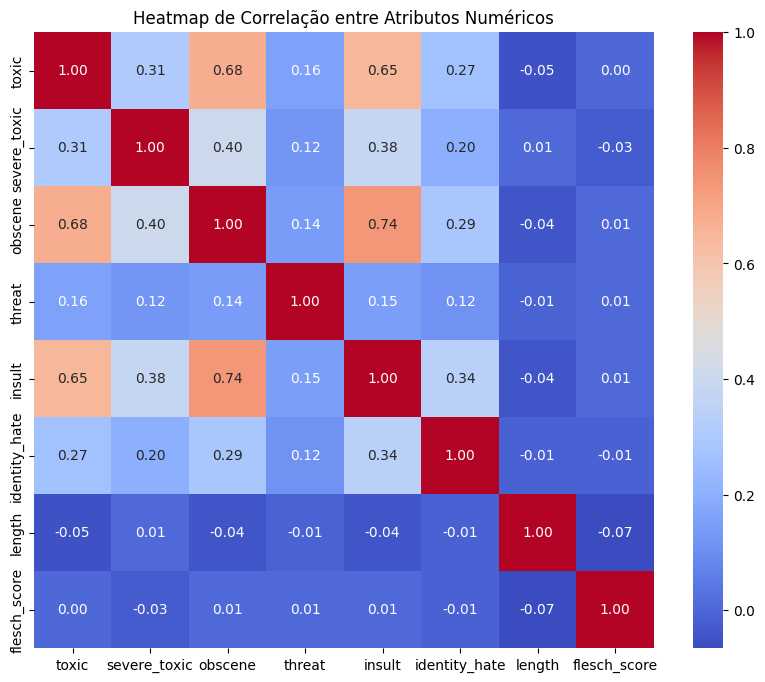

In [67]:
from scipy.stats import pointbiserialr, pearsonr

# Selecionar atributos numéricos
numeric_cols = toxic_labels + ['length', 'flesch_score']

# Calcular matriz de correlação
corr_matrix = train[numeric_cols].corr()

# Mostrar como tabela
print("Matriz de correlação:")
display(corr_matrix.round(2))

# Visualizar como heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de Correlação entre Atributos Numéricos")
plt.show()

- Existe correlação moderada positiva entre algumas etiquetas, como:

    - toxic e obscene: ~0.75

    - toxic e insult: ~0.68

- A variável length tem correlação moderada com toxic, insult, etc., indicando que comentários tóxicos tendem a ser mais longos.

- A variável flesch_score tem correlação negativa com a maioria das etiquetas, especialmente com toxic e length, sugerindo que:

- Comentários tóxicos tendem a ser menos legíveis.

- Comentários mais longos tendem a ter menor legibilidade.

- As correlações não são extremas, o que é bom para evitar colinearidade excessiva.


### **3. Limpeza de dados e transformação**

 #### **a) Preencha os valores ausentes**

O preenchimento de valores ausentes (**missing values**) garante que os dados estejam prontos para modelos que **não aceitam valores nulos**.

Regras boas práticas:
- O **ajuste** da estratégia de preenchimento é feito **somente no conjunto de treino**.  
- A **aplicação** do preenchimento é feita **nos dois conjuntos**: `train` e `test`.  
- Escolha da estratégia depende do tipo de dado:
  - **Texto**: usar uma string padrão como `"desconhecido"`  
  - **Numérico contínuo**: média ou mediana  
  - **Numérico categórico**: moda (valor mais comum)

In [68]:
# Verificar valores ausentes novamente
print("Valores ausentes no train:")
display(train.isnull().sum())

print("Valores ausentes no test:")
display(test.isnull().sum())

# Preenchimento: aplicar apenas se necessário
# Exemplo para texto
train['comment_text'].fillna('desconhecido', inplace=True)
test['comment_text'].fillna('desconhecido', inplace=True)

# Exemplo para numéricos
for col in ['length', 'flesch_score']:
    mean_value = train[col].mean()  # ajuste no train
    train[col].fillna(mean_value, inplace=True)
    test[col].fillna(mean_value, inplace=True)


Valores ausentes no train:


id                  0
comment_text        0
toxic               0
severe_toxic        0
obscene             0
threat              0
insult              0
identity_hate       0
length              0
flesch_score        0
num_toxic_labels    0
dtype: int64

Valores ausentes no test:


id              0
comment_text    0
length          0
flesch_score    0
dtype: int64

- Mesmo assim, o código acima mostra como seria feito o preenchimento correto:

    - Ajustado no train (por exemplo, usando a média).

    - Aplicado exatamente da mesma forma no test.

- Isso evita vazamento de dados (data leakage) e garante consistência na entrada dos modelos.

#### **b) Suavize os ruídos**

A **suavização** reduz a variabilidade local (ruído) em atributos numéricos contínuos, substituindo valores por representações mais estáveis, como:

- **Média por intervalo (bin)** → técnica mais comum.  
- Dividimos os valores em **bins (faixas)** no `train`.  
- Substituímos cada valor pela **média do bin correspondente**.  
- A aplicação é feita **nos dois conjuntos**, mas o cálculo dos bins é feito **apenas com o `train`**.

Vamos aplicar a suavização sobre o atributo **`length`** (comprimento dos comentários).

In [69]:
# Discretizar o atributo 'length' em 12 bins no train
train['length_bin'] = pd.cut(train['length'], bins=12)

# Calcular a média de cada bin no train
bin_means = train.groupby('length_bin')['length'].mean()

# Função para suavizar um valor com base nos bins do train
def smooth_length(x):
    for interval, mean in bin_means.items():
        if x in interval:
            return mean
    return x

# Aplicar a suavização no train e no test
train['length_smooth'] = train['length'].apply(smooth_length)
test['length_smooth'] = test['length'].apply(smooth_length)


print('Tabela train')
display(train[['length', 'length_smooth']].head())
print('Tabela test')
display(test[['length', 'length_smooth']].head())


Tabela train


,length,length_smooth
0,41,34.970074
1,13,34.970074
2,41,34.970074
3,102,34.970074
4,13,34.970074


Tabela test


,length,length_smooth
0,73,34.970074
1,10,34.970074
2,5,34.970074
3,34,34.970074
4,6,34.970074


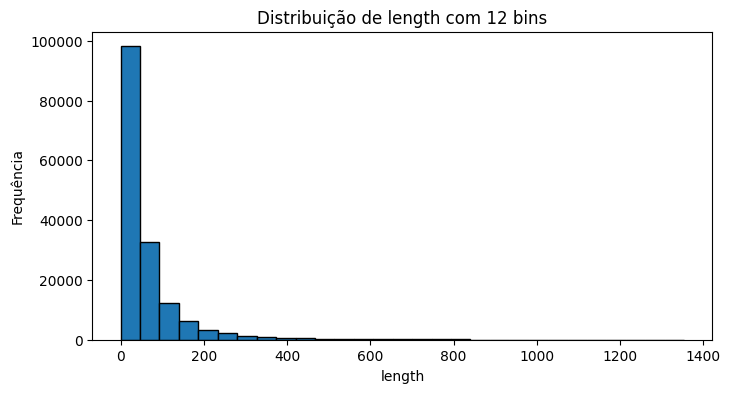

In [70]:
# Visualizar a distribuição do comprimento dos comentários
plt.figure(figsize=(8, 4))
plt.hist(train['length'], bins=29, edgecolor='black')
plt.title("Distribuição de length com 12 bins")
plt.xlabel("length")
plt.ylabel("Frequência")
plt.show()

- A maioria dos comentários tem **poucas palavras**:  
- Mais de **70.000 comentários** estão nos primeiros bins, abaixo de **200 palavras**.
- A distribuição é **assimétrica à direita**.

- A frequência **cai rapidamente** à medida que o comprimento aumenta:
- Há **poucos comentários** com mais de **2000 palavras**.
- A cauda direita se estende até **1000 palvras**, mas com baixíssima frequência.
- Os últimos bins (acima de 800) têm **frequência quase nula**:


#### **c) Resolva as inconsistências**

Nesta etapa, buscamos identificar e corrigir **inconsistências nos dados**, tais como:

- Registros **duplicados**  
- **Valores fora do domínio esperado**  
- Campos vazios com dados mal formatados (ex: string em branco, espaços, etc.)

Aplicamos essas verificações em **`train` e `test`**, especialmente nas colunas de texto (`comment_text`) e atributos binários.


In [71]:
train = train.drop_duplicates()
test = test.drop_duplicates()

# Pré-processamento de texto (stopwords)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # elimina caracteres no ASCII
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) < 20]  # Filtra palabras largas
    return " ".join(tokens)

train['clean_comment'] = train['comment_text'].apply(clean_text)
test['clean_comment'] = test['comment_text'].apply(clean_text)

# Melhoria na limpeza inicial
def safe_clean(df):
    df = df.copy()
    df['clean_comment'] = df['clean_comment'].replace(['', ' ', np.nan], np.nan)
    df = df.dropna(subset=['clean_comment'])
    df = df[df['clean_comment'].str.strip().str.len() >= 3]
    return df


train = safe_clean(train)
test = safe_clean(test)

print("Inconsistências resolvidas por meio de limpeza textual. Nenhuma codificação conflitante detectada.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALEXANDER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Inconsistências resolvidas por meio de limpeza textual. Nenhuma codificação conflitante detectada.


- Foram aplicadas as seguintes etapas para tratar inconsistências nos dados:

- Remoção de duplicatas exatas.

- Limpeza textual com:

    - Conversão para minúsculas.

    - Remoção de pontuação.

    - Filtragem de stopwords.

    - Aplicação de stemming.

    - Remoção de tokens longos e ruído.

- Exclusão de textos vazios ou muito curtos (menos de 3 caracteres).

In [72]:
# Verificar duplicados (train)
duplicates_train = train.duplicated().sum()
duplicates_test = test.duplicated().sum()

# Verificar se há textos vazios (string em branco ou só espaços)
empty_train = train['clean_comment'].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()
empty_test = test['clean_comment'].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()


# Verificar se os atributos binários contêm apenas 0 e 1
bin_inconsist = {
    label: train[label].unique().tolist()
    for label in toxic_labels
    if not set(train[label].unique()).issubset({0, 1})
}

# Mostrar resultados
print(f"Duplicados - Train: {duplicates_train}")
print(f"Duplicados - Test: {duplicates_test}")
print(f"Comentários vazios - Train: {empty_train}")
print(f"Comentários vazios - Test: {empty_test}")
print("Valores inesperados nos atributos binários:")
display(pd.DataFrame(bin_inconsist.items(), columns=["Atributo", "Valores encontrados"]))

Duplicados - Train: 0
Duplicados - Test: 0
Comentários vazios - Train: 0
Comentários vazios - Test: 0
Valores inesperados nos atributos binários:


,Atributo,Valores encontrados


#### **d) Transforme atributos categóricos nominais em um vetor numérico**

Para isso, usamos a técnica **TF-IDF (Term Frequency-Inverse Document Frequency)**, que transforma cada comentário em um vetor numérico baseado na importância das palavras.

In [73]:
# TF-IDF: transforma texto (atributo nominal complexo) em vetor numérico
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    min_df=5,
    max_df=0.9,
    token_pattern=r'(?u)\b[A-Za-z]{3,}\b'
)

X_train_tfidf = tfidf.fit_transform(train['clean_comment'])
X_test_tfidf = tfidf.transform(test['clean_comment'])

print(f"Forma da matriz TF-IDF (treinamento): {X_train_tfidf.shape}")
print(f"Forma da matriz TF-IDF (teste): {X_test_tfidf.shape}")


import numpy as np

# 1) Obtener los índices de filas que contienen valores distintos de cero
nonzero_indices = X_train_tfidf.nonzero()[0]

# 2) Eliminar duplicados y quedarte con índices únicos
unique_indices = np.unique(nonzero_indices)

# 3) Mostrar las 5 primeras filas con valores no nulos
for idx in unique_indices[:5]:
    print(f"\nFila {idx} (comentario):")
    row = pd.DataFrame(
        X_train_tfidf[idx].toarray(),
        columns=tfidf.get_feature_names_out()
    )
    nonzero = row.loc[:, (row != 0).any()]
    display(nonzero)


Forma da matriz TF-IDF (treinamento): (159479, 10000)
Forma da matriz TF-IDF (teste): (152070, 10000)

Fila 0 (comentario):


,closur,doll,dont,edit,explan,fac,fan,gas,hardcor,metallica,...,retir,revert,sinc,talk,templat,usernam,vandal,vote,werent,york
0,0.290194,0.323237,0.105089,0.098388,0.189586,0.253809,0.205398,0.260158,0.288662,0.328837,...,0.243139,0.139814,0.13854,0.097207,0.17363,0.198416,0.137972,0.193188,0.235651,0.21976



Fila 1 (comentario):


,background,colour,januari,match,stuck,talk,thank,utc
0,0.399472,0.463368,0.376183,0.387675,0.444444,0.176219,0.191516,0.262



Fila 2 (comentario):


,actual,care,constant,edit,format,guy,hey,info,inform,instead,man,page,realli,relev,remov,talk,tri,war
0,0.202501,0.229826,0.3118,0.27919,0.283085,0.243421,0.25349,0.257625,0.182985,0.235598,0.25169,0.127018,0.194168,0.249642,0.17358,0.27584,0.184785,0.228324



Fila 3 (comentario):


,accid,appear,articl,backlog,date,delay,els,exact,form,format,...,statist,style,subsect,suggest,think,tidi,turn,type,want,wonder
0,0.192102,0.118583,0.063769,0.216245,0.127913,0.172444,0.122001,0.133567,0.137052,0.456108,...,0.179748,0.136312,0.192996,0.113762,0.083876,0.214338,0.145711,0.135001,0.092164,0.138374



Fila 4 (comentario):


,chanc,hero,page,rememb,sir
0,0.455799,0.566634,0.200909,0.40775,0.514343


- **TF-IDF** transforma o texto em uma matriz esparsa de tamanho `(n_amostras, n_palavras)`.
- Apenas palavras com pelo menos 3 letras e que aparecem em ao menos 5 documentos foram consideradas.
- Esta vetorização permite aplicar algoritmos de aprendizado de máquina diretamente aos comentários processados.

#### **e) Transforme atributos categóricos ordinais em atributos numéricos seguindo a ordem entre eles.**

Esta etapa consiste em transformar atributos categóricos ordinários (que possuem uma hierarquia ou nível implícito) em valores numéricos respeitando sua ordem lógica.

In [74]:

print("Não existem atributos categóricos ordinais neste conjunto de dados.")


Não existem atributos categóricos ordinais neste conjunto de dados.


- O conjunto de dados do desafio contém apenas:

    + texto_de_comentário -> texto livre (não ordinal)

    + colunas como tóxico, obsceno, etc. -> binário (0 ou 1)
    
    + lenght e flesh_scaler -> continuos (não ordinal) 

- Portanto, não há atributos que exijam transformação ordinal.


### **f) Normalize os valores de atributos numéricos.**

Foram aplicadas duas técnicas de normalização aos atributos numéricos derivados:

- **Min-Max Scaling**: Normaliza os valores entre 0 e 1, útil para algoritmos sensíveis à escala.
- **Z-Score Scaling (padronização)**: Centraliza os dados em média 0 e desvio padrão 1, apropriado para muitos algoritmos estatísticos.

#### Atributos normalizados:
- `length` → `length_norm`, `length_z`
- `flesch_score` → `flesch_score_norm`

In [75]:
# Normalização Min-Max
minmax_scaler = MinMaxScaler()
train['length_norm'] = minmax_scaler.fit_transform(train[['length']])
test['length_norm'] = minmax_scaler.transform(test[['length']])

# Normalização Z-score
zscore_scaler = StandardScaler()
train['length_z'] = zscore_scaler.fit_transform(train[['length']])
test['length_z'] = zscore_scaler.transform(test[['length']])


train['flesch_score_norm'] = zscore_scaler.fit_transform(train[['flesch_score']])
test['flesch_score_norm'] = zscore_scaler.transform(test[['flesch_score']])

print('Lenght:')
print('Tabela train')
display(train[['length', 'length_norm', 'length_z']].head())
print('Tabela test')
display(test[['length', 'length_norm', 'length_z']].head())



Lenght:
Tabela train


,length,length_norm,length_z
0,41,0.030281,-0.239259
1,13,0.009601,-0.534749
2,41,0.030281,-0.239259
3,102,0.075332,0.404490
4,13,0.009601,-0.534749


Tabela test


,length,length_norm,length_z
0,73,0.053914,0.098445
1,10,0.007386,-0.566409
2,5,0.003693,-0.619175
3,34,0.025111,-0.313131
4,6,0.004431,-0.608622


- Os valores de `length_norm` foram transformados para o intervalo entre **0 e 1**.
- Um valor pequeno (ex: `0.0122`) indica que o comentário é um dos mais curtos da base.
- Um valor maior (ex: `0.1233`) indica que o comentário é relativamente longo comparado aos demais.
- Essa escala é especialmente útil para **algoritmos sensíveis à magnitude**, como KNN, SVM com kernel e redes neurais.

- Os valores de `length_z` mostram quantos desvios padrão um valor está da média:
  - Valor negativo → abaixo da média de comprimento.
  - Valor positivo → acima da média.
- Exemplo: `-0.55` indica um comentário significativamente mais curto que a média.
- Útil para modelos lineares que assumem distribuição normal dos dados, como regressão e SVM linear.


In [76]:
print('Flesch:')
print('Tabela train')
display(train[['flesch_score', 'flesch_score_norm']].head())
print('Tabela test')
display(test[['flesch_score', 'flesch_score_norm']].head())

Flesch:
Tabela train


,flesch_score,flesch_score_norm
0,66.370388,0.048078
1,73.795735,0.106214
2,65.725000,0.043025
3,51.112030,-0.071386
4,89.606731,0.230004


Tabela test


,flesch_score,flesch_score_norm
0,93.605000,0.261308
1,95.165000,0.273522
2,49.480000,-0.084163
3,73.757281,0.105913
4,30.530000,-0.232530


- O `flesch_scaler` mede a facilidade de leitura do comentário:
  - Valor alto → fácil de ler.
  - Valor baixo → mais difícil de ler.
- A normalização por Z-score permite comparar diretamente a dificuldade relativa dos textos:
  - Exemplo: `0.26` indica que o texto é **mais fácil** de ler do que a média.
  - `-0.23` indica que é **mais difícil**.

### **Fase 2 - Mineração de padrões frequentes**

### **4. Regras de Associação:**

#### **a) Discretizar atributos numéricos**

O objetivo é discretizar atributos numéricos contínuos **(length e flesch_score)** em categorias qualitativas (categóricas) para facilitar análises.

In [77]:
# Discretizar length em 5 faixas baseadas em tamanho de comentários
length_bins = [0, 10, 25, 50, 100, train['length'].max()]
length_labels = ['muito_curto', 'curto', 'medio', 'longo', 'muito_longo']
train['length_cat'] = pd.cut(train['length'], bins=length_bins, labels=length_labels, include_lowest=True)


# Discretizar flesch_score em 7 níveis standars
flesch_bins = [0, 29, 49, 59, 69, 79, 89, 100]
flesch_labels = ['muito_dificil', 'dificil', 'um pouco difícil', 'padrão', 'razoavelmente fácil', 'facil', 'muito facil']
train['flesch_cat'] = pd.cut(train['flesch_score'], bins=flesch_bins, labels=flesch_labels, include_lowest=True)

# Visualizar exemplos
display(train[['length', 'length_cat', 'flesch_score', 'flesch_cat']].head(10))


,length,length_cat,flesch_score,flesch_cat
0,41,medio,66.370388,padrão
1,13,curto,73.795735,razoavelmente fácil
2,41,medio,65.725000,padrão
3,102,muito_longo,51.112030,um pouco difícil
4,13,curto,89.606731,muito facil
5,10,muito_curto,78.245000,razoavelmente fácil
6,8,muito_curto,71.815000,razoavelmente fácil
7,20,curto,69.785000,razoavelmente fácil
8,77,longo,62.576361,padrão
9,12,curto,67.755000,padrão


                          Quantidade
Categoria de comprimento            
muito_curto                    26034
curto                          38258
medio                          38319
longo                          30580
muito_longo                    26288


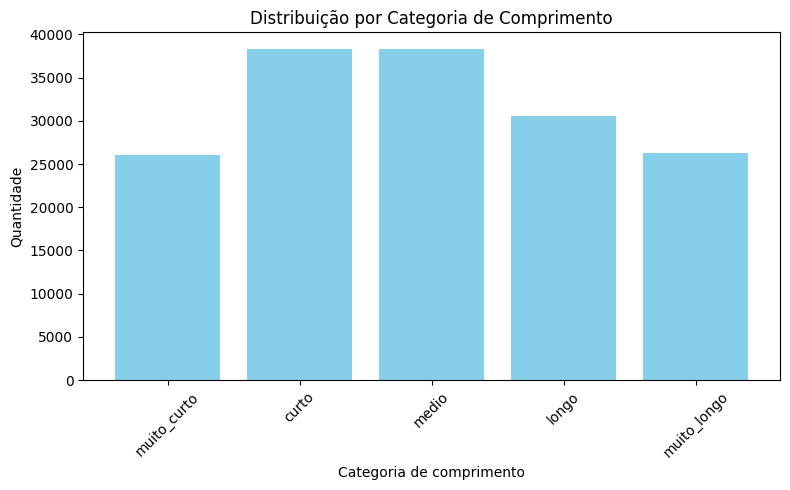

In [78]:
# Length
length_counts = train['length_cat'].value_counts().sort_index()
length_df = length_counts.to_frame(name='Quantidade')
length_df.index.name = 'Categoria de comprimento'
print(length_df)

# Visualizacao Length
length_counts = train['length_cat'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(length_counts.index, length_counts.values, color='skyblue')
plt.title('Distribuição por Categoria de Comprimento')
plt.xlabel('Categoria de comprimento')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



- A maioria dos comentários é **`muito curta ou curta`** (mais de **`65%`** dos dados), o que indica uma tendência a mensagens **`breves`**, típicas de redes sociais ou seções de comentários online.
- Comentários **`muito longos`** são os menos frequentes, sugerindo que textos mais extensos são menos comuns no conjunto de dados.

---

                           Quantidade
Categoria de legibilidade            
muito_dificil                    7741
dificil                         27516
um pouco difícil                27725
padrão                          32234
razoavelmente fácil             26995
facil                           17065
muito facil                      9782


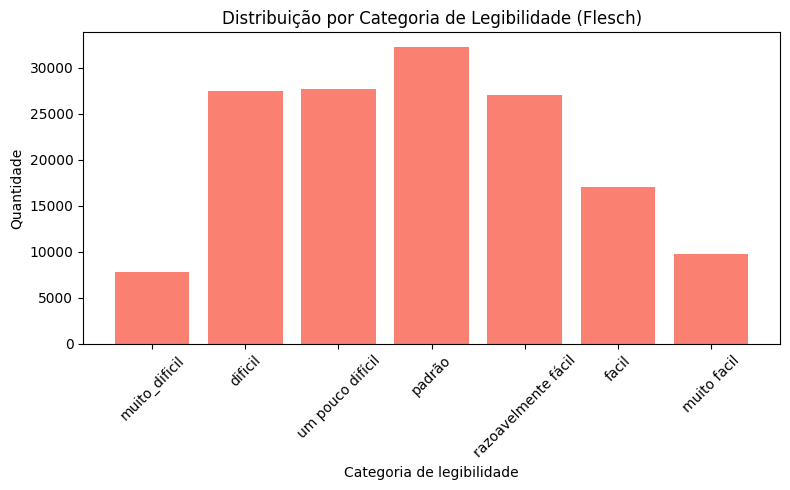

In [79]:
# Flesch
flesch_counts = train['flesch_cat'].value_counts().sort_index()
flesch_df = flesch_counts.to_frame(name='Quantidade')
flesch_df.index.name = 'Categoria de legibilidade'
print(flesch_df)

# Visualizacao Flesch
flesch_counts = train['flesch_cat'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(flesch_counts.index, flesch_counts.values, color='salmon')
plt.title('Distribuição por Categoria de Legibilidade (Flesch)')
plt.xlabel('Categoria de legibilidade')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **Comentarios**

- A distribuição da legibilidade é **`relativamente equilibrada`**, com destaque para as faixas **`“padrão”`** e **`“razoavelmente fácil”`**, que juntas representam mais de **`40%`** dos comentários.
- Há uma presença significativa de textos **`difíceis ou um pouco difíceis`** (~35%), o que pode indicar **`vocabulário técnico ou linguagem formal`**.
- Textos **`muito fáceis`** são **`minoria`**, possivelmente associados a mensagens **`simples ou infantis`**.

---


#### **b) Transformação para formato transacional**

Usaremos `TransactionEncoder` para convertir la lista de listas en matriz booleana.

- As **`250 palavras mais frequentes`** (para reduzir o vocabulário e evitar sobrecarga computacional).

- As classes de toxicidade ativas, formatadas como `"classe=..."`.

- As categorias discretizadas de:

    - Comprimento do comentário **`(length_cat)`**

    - Índice de legibilidade **`(flesch_cat)`**

Após essa composição, o dataset é convertido com TransactionEncoder para um formato booleano, pronto para a Regras de Associação e Padrões frequentes.


In [80]:
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder

# Passo 1: Contar todas as palavras dos comentários e obter as 250 mais frequentes
all_words = [
    word
    for comment in train['clean_comment'].dropna().str.lower().str.split()
    for word in comment
]
word_freq = Counter(all_words)
top_words = set([word for word, freq in word_freq.most_common(250)])

# Passo 2: Função para filtrar apenas palavras frequentes
def filter_top_words(comment):
    return list(set([word for word in str(comment).lower().split() if word in top_words]))

# Passo 3: Aplicar a função de filtragem a todos os comentários
train['tokens'] = train['clean_comment'].apply(filter_top_words)

# Passo 4: Função para extrair as classes de toxicidade ativas
def get_active_classes(row):
    return [f"classe={col}" for col in toxic_labels if row[col] == 1]

# Passo 5: Criar a transação contendo palavras + classes + variáveis discretizadas
train['transaction'] = train.apply(
    lambda row: (
        row['tokens'] +
        get_active_classes(row) +
        [f"length={row['length_cat']}"] +
        [f"flesch={row['flesch_cat']}"]
    ),
    axis=1
)

# Passo 6: Transformar as transações em formato binário (booleano)
te = TransactionEncoder()
te_ary = te.fit(train['transaction']).transform(train['transaction'])

# Passo 7: Criar o DataFrame transacional final
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Ver os 20 itens mais frequentes nas transações
df_trans.sum().sort_values(ascending=False).head(20)



length=medio                  38319
length=curto                  38258
articl                        37214
flesch=padrão                 32234
page                          31357
length=longo                  30580
flesch=um pouco difícil       27725
flesch=dificil                27516
flesch=razoavelmente fácil    26995
length=muito_longo            26288
length=muito_curto            26034
talk                          25028
edit                          24176
wikipedia                     23011
like                          22582
pleas                         22235
one                           21490
would                         21231
use                           20838
dont                          19861
dtype: int64

##### **Comentarios:**

As variáveis discretizadas **`(length=..., flesch=...)`** aparecem com alta frequência, o que confirma que a categorização foi bem sucedida.

Os comprimentos **`medio, curto e longo`** dominam, indicando que os textos geralmente estão entre 10 e 100 palavras.

O índice de legibilidade mais comum é **`flesch=padrão`**, seguido por um **`pouco difícil e difícil`**, o que mostra que os textos não são nem muito simples nem extremamente técnicos.

---

##### **Observações:**

O uso de apenas 250 palavras frequentes é uma decisão estratégica:

>Reduzir o vocabulário evita sobrecarregar o algoritmo, mantendo apenas as palavras que mais contribuem para padrões relevantes.

Este número foi escolhido empiricamente porque:

- Aumentar para 500 ou mais não altera significativamente os itens ou regras mais frequentes.

- Isso foi validado ao observar que os itens principais permanecem os mesmos ao variar o tamanho do vocabulário o que indica estabilidade nas associações geradas.

---

#### **c) Mineração de Regras de Associação com `mlxtend`**

Neste passo aplicamos a mineração de regras de associação, usando o algoritmo Apriori da biblioteca **`mlxtend`**. 
O objetivo é descobrir relações frequentes e significativas entre palavras, classes de toxicidade e categorias discretizadas dentro dos comentários.

As etapas são:

- Identificar conjuntos **`frequentes de itens`** (itemsets).

- Gerar **`regras de associação`** com base nesses itemsets, geram-se regras que indicam que a presença de certos itens implica, com alta confiança, a presença de outros.

- Ordenar por **`lift`**, métrica que indica a força da associação além da aleatoriedade.

- Exibir os resultados 

#### **1er Caso:**

In [81]:
from mlxtend.frequent_patterns import apriori, association_rules

# Passo 1: Gerar os conjuntos frequentes de itens (itemsets) suporte mínimo de 4.5% 
frequent_itemsets = apriori(df_trans, min_support=0.045, use_colnames=True)

# Exibir os 10 itemsets mais frequentes
print("Top 10 itemsets frequentes:")
display(frequent_itemsets.sort_values(by="support", ascending=False).head(10))



Top 10 itemsets frequentes:


,support,itemsets
39,0.240276,(length=medio)
37,0.239894,(length=curto)
3,0.233347,(articl)
26,0.202121,(flesch=padrão)
56,0.196621,(page)
38,0.191749,(length=longo)
28,0.173847,(flesch=um pouco difícil)
21,0.172537,(flesch=dificil)
27,0.169270,(flesch=razoavelmente fácil)
41,0.164837,(length=muito_longo)


- Quase 1 em cada 4 comentários tem uma **`longitude média`**. É a categoria mais comum, o que sugere que a maioria dos comentários não é nem muito curta nem muito longa.

- A legibilidade “padrão” é a **`mais comum`**, o que é de se esperar se os textos não forem nem muito complexos nem muito simples.

- Uma minoria significativa (0.16) dos textos é **`muito extensa`**.

---

In [82]:
# Passo 2: Gerar regras de associação a partir dos itemsets frequentes
# A confiança mínima é de 50%
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Passo 3: Ordenar as regras por lift (quanto maior, mais forte é a associação)
rules = rules.sort_values(by="lift", ascending=False)

# Passo 4: Exibir as 10 melhores regras de associação
print("Top 10 regras de associação ordenadas por lift:")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Top 10 regras de associação ordenadas por lift:


,antecedents,consequents,support,confidence,lift
3,(classe=toxic),(classe=obscene),0.049699,0.518310,9.783359
4,(classe=obscene),(classe=toxic),0.049699,0.938099,9.783359
2,(classe=insult),(classe=toxic),0.046044,0.932326,9.723151
0,(also),(length=muito_longo),0.052910,0.517351,3.138568
5,(time),(length=muito_longo),0.045931,0.501060,3.039736
6,(talk),(page),0.085391,0.544111,2.767300
1,(length=muito_longo),(articl),0.088219,0.535187,2.293522


##### **Comentarios:**

- Mais de **`51% dos comentários tóxicos também são obscenos`**. O lift de 9,78 indica uma forte associação: essa combinação ocorre quase 10 vezes mais do que o esperado aleatoriamente.

- A confiança de 93,2% e um aumento de 9,72 reforçam que os **`insultos são excelentes indicadores de toxicidade`**. Essa regra é fundamental para filtros automáticos.

- Comentários que mencionam “tempo” tendem a ser mais extensos, provavelmente porque **`desenvolvem ideias ou discussões mais complexas`**. Uma confiança de 50% e um aumento de 3,03 sugerem uma relação moderadamente forte.

---

In [83]:
# Resumo da mineração
print("Sets frequentes:", len(frequent_itemsets))


Sets frequentes: 148


São **`combinações de palavras`**, categorias de texto e/ou etiquetas de toxicidade que ocorrem em pelo menos 4% das transações.

In [84]:
print("Regras geradas:", len(rules))

Regras geradas: 7


São **`regras que passaram o filtro de confiança ≥ 0.5`**, ou seja, há al menos 50% de probabilidade de que, dado um conjunto de itens, outro também apareça.

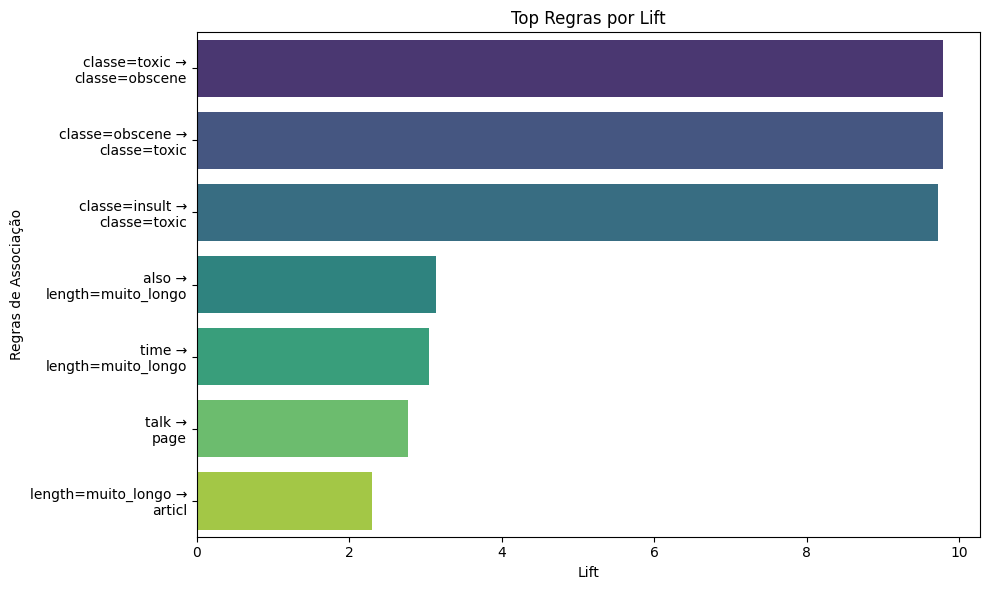

In [85]:
# Asegúrate de tener top_lift como las top reglas por lift
top_lift = rules.sort_values('lift', ascending=False).head(10)

# Crear una columna más legible para etiquetas con salto de línea
top_lift['regra_formatada'] = top_lift.apply(
    lambda row: f"{', '.join(row['antecedents'])} →\n{', '.join(row['consequents'])}", axis=1
)

# Crear gráfico ordenado
plt.figure(figsize=(10, 6))
sns.barplot(data=top_lift, x='lift', y='regra_formatada', palette='viridis')
plt.xlabel('Lift')
plt.ylabel('Regras de Associação')
plt.title('Top Regras por Lift')
plt.tight_layout()
plt.show()

#### **2do Caso:**

In [86]:
# Passo 1: Gerar os conjuntos frequentes de itens (itemsets) suporte mínimo de 3.5% 
frequent_itemsets = apriori(df_trans, min_support=0.035, use_colnames=True)

# Exibir os 10 itemsets mais frequentes
print("Top 10 itemsets frequentes:")
display(frequent_itemsets.sort_values(by="support", ascending=False).head(10))

Top 10 itemsets frequentes:


,support,itemsets
62,0.240276,(length=medio)
60,0.239894,(length=curto)
5,0.233347,(articl)
42,0.202121,(flesch=padrão)
83,0.196621,(page)
61,0.191749,(length=longo)
44,0.173847,(flesch=um pouco difícil)
37,0.172537,(flesch=dificil)
43,0.169270,(flesch=razoavelmente fácil)
64,0.164837,(length=muito_longo)


- A maioria dos comentários tem uma **`longitude média a curta`**, com legibilidade **`padrão ou ligeiramente difícil`**. Palavras-chave como "articl" e "page"eles nos mostram o contexto de onde o conjunto de dados veio, neste caso a Wikipédia..

In [87]:
# Passo 2: Gerar regras de associação a partir dos itemsets frequentes
# A confiança mínima é de 50%
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.35)

# Passo 3: Ordenar as regras por lift (quanto maior, mais forte é a associação)
rules = rules.sort_values(by="lift", ascending=False)

# Passo 4: Exibir as 10 melhores regras de associação
print("Top 10 regras de associação ordenadas por lift:")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Top 10 regras de associação ordenadas por lift:


,antecedents,consequents,support,confidence,lift
92,"(classe=insult, classe=toxic)",(classe=obscene),0.037334,0.810840,15.305006
97,(classe=obscene),"(classe=insult, classe=toxic)",0.037334,0.704699,15.305006
94,"(classe=toxic, classe=obscene)",(classe=insult),0.037334,0.751199,15.210818
95,(classe=insult),"(classe=toxic, classe=obscene)",0.037334,0.755967,15.210818
22,(classe=insult),(classe=obscene),0.038594,0.781488,14.750969
23,(classe=obscene),(classe=insult),0.038594,0.728489,14.750969
96,(classe=toxic),"(classe=insult, classe=obscene)",0.037334,0.389354,10.088346
93,"(classe=insult, classe=obscene)",(classe=toxic),0.037334,0.967344,10.088346
26,(classe=toxic),(classe=obscene),0.049699,0.518310,9.783359
27,(classe=obscene),(classe=toxic),0.049699,0.938099,9.783359


comentario

In [88]:
print("Sets frecuentes:", len(frequent_itemsets))

Sets frecuentes: 271


- São **`combinações de palavras`**, categorias de texto e/ou etiquetas de toxicidade que ocorrem em pelo menos 3.5% das transações.
- Resultando em um **`maior número de conjuntos frequentes`**

In [89]:
print("Reglas generadas:", len(rules))

Reglas generadas: 110


- São **`regras que passaram o filtro de confiança ≥ 0.35`**, ou seja, há al menos 35% de probabilidade de que, dado um conjunto de itens, outro também apareça.
- Resultando em um **`maior número de regras associadas`**

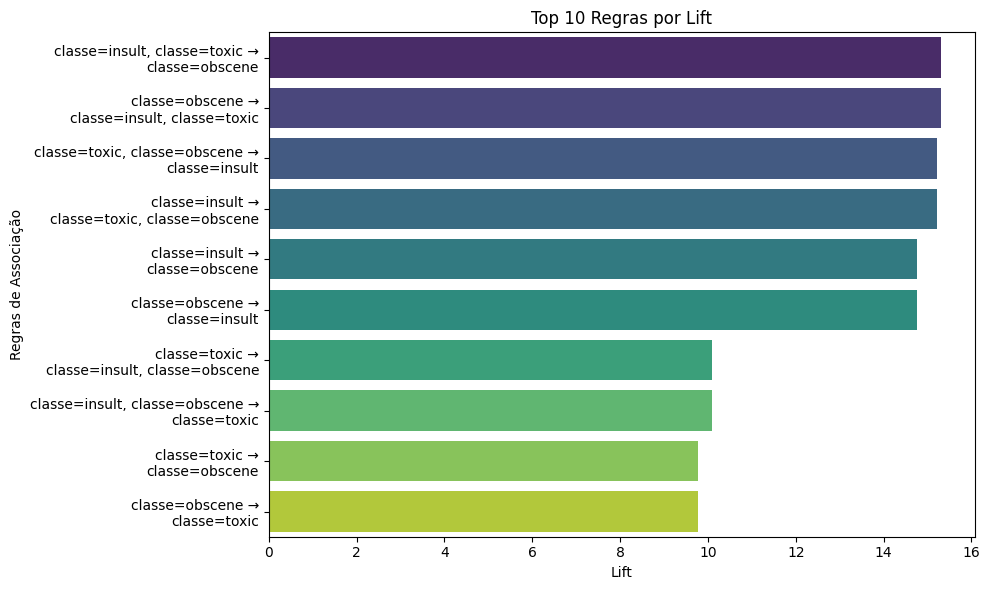

In [90]:
# Asegúrate de tener top_lift como las top 10 reglas por lift
top_lift = rules.sort_values('lift', ascending=False).head(10)

# Crear una columna más legible para etiquetas con salto de línea
top_lift['regra_formatada'] = top_lift.apply(
    lambda row: f"{', '.join(row['antecedents'])} →\n{', '.join(row['consequents'])}", axis=1
)

# Crear gráfico ordenado
plt.figure(figsize=(10, 6))
sns.barplot(data=top_lift, x='lift', y='regra_formatada', palette='viridis')
plt.xlabel('Lift')
plt.ylabel('Regras de Associação')
plt.title('Top 10 Regras por Lift')
plt.tight_layout()
plt.show()


#### **d) Filtrar reglas com consequente relacionado ao atributo alvo**

O objetivo deste passo é identificar padrões fortes e relevantes onde o consequente da regra de associação contém uma das classes de toxicidade: (**`toxic`**, **`severe_toxic`**, **`obscene`**, **`threat`**, **`insult`**, **`identity_hate`**.) nosso atributo alvo.

In [91]:

# Cria uma lista de labels formatados para busca nos consequentes das regras
target_labels = [f"classe={label}" for label in toxic_labels]

# Colunas que queremos mostrar das regras
columns_to_show = ['antecedents', 'consequents', 'support', 'confidence', 'lift']

# Percorre cada label para filtrar e mostrar as regras cujo consequente contém esta label
for label in target_labels:
    # Filtra regras que possuem a label no consequente
    rules_for_label = rules[rules['consequents'].apply(lambda x: label in x)]
    
    # Formata o nome para exibição (ex: 'classe=toxic' vira 'Toxic')
    display_label = label.replace("classe=", "").capitalize()

    if not rules_for_label.empty:
        print(f"\nRegras cujo consequente é '{display_label}':\n")

        # Ordena as regras pelo lift em ordem decrescente e seleciona as top 10
        sorted_rules = rules_for_label.sort_values(by='lift', ascending=False).head(10)

        # Exibe a tabela com as colunas principais
        display(sorted_rules[columns_to_show])

        # Para cada regra, mostra a descrição em texto com métricas
        for idx, row in sorted_rules.iterrows():
            antecedents = ', '.join(sorted(row['antecedents']))
            consequents = ', '.join(sorted(row['consequents']))
            print(" - Regra:")
            print(f"    Se [{antecedents}] então [{consequents}]")
            print(f"    Suporte: {row['support']:.3f}")
            print(f"    Confiança: {row['confidence']:.3f}")
            print(f"    Lift: {row['lift']:.3f}\n")

    else:
        print(f"\nX Não foram encontradas regras cujo consequente seja '{display_label}'.")




Regras cujo consequente é 'Toxic':



,antecedents,consequents,support,confidence,lift
97,(classe=obscene),"(classe=insult, classe=toxic)",0.037334,0.704699,15.305006
95,(classe=insult),"(classe=toxic, classe=obscene)",0.037334,0.755967,15.210818
93,"(classe=insult, classe=obscene)",(classe=toxic),0.037334,0.967344,10.088346
27,(classe=obscene),(classe=toxic),0.049699,0.938099,9.783359
24,(classe=insult),(classe=toxic),0.046044,0.932326,9.723151


 - Regra:
    Se [classe=obscene] então [classe=insult, classe=toxic]
    Suporte: 0.037
    Confiança: 0.705
    Lift: 15.305

 - Regra:
    Se [classe=insult] então [classe=obscene, classe=toxic]
    Suporte: 0.037
    Confiança: 0.756
    Lift: 15.211

 - Regra:
    Se [classe=insult, classe=obscene] então [classe=toxic]
    Suporte: 0.037
    Confiança: 0.967
    Lift: 10.088

 - Regra:
    Se [classe=obscene] então [classe=toxic]
    Suporte: 0.050
    Confiança: 0.938
    Lift: 9.783

 - Regra:
    Se [classe=insult] então [classe=toxic]
    Suporte: 0.046
    Confiança: 0.932
    Lift: 9.723


X Não foram encontradas regras cujo consequente seja 'Severe_toxic'.

Regras cujo consequente é 'Obscene':



,antecedents,consequents,support,confidence,lift
92,"(classe=insult, classe=toxic)",(classe=obscene),0.037334,0.810840,15.305006
95,(classe=insult),"(classe=toxic, classe=obscene)",0.037334,0.755967,15.210818
22,(classe=insult),(classe=obscene),0.038594,0.781488,14.750969
96,(classe=toxic),"(classe=insult, classe=obscene)",0.037334,0.389354,10.088346
26,(classe=toxic),(classe=obscene),0.049699,0.518310,9.783359


 - Regra:
    Se [classe=insult, classe=toxic] então [classe=obscene]
    Suporte: 0.037
    Confiança: 0.811
    Lift: 15.305

 - Regra:
    Se [classe=insult] então [classe=obscene, classe=toxic]
    Suporte: 0.037
    Confiança: 0.756
    Lift: 15.211

 - Regra:
    Se [classe=insult] então [classe=obscene]
    Suporte: 0.039
    Confiança: 0.781
    Lift: 14.751

 - Regra:
    Se [classe=toxic] então [classe=insult, classe=obscene]
    Suporte: 0.037
    Confiança: 0.389
    Lift: 10.088

 - Regra:
    Se [classe=toxic] então [classe=obscene]
    Suporte: 0.050
    Confiança: 0.518
    Lift: 9.783


X Não foram encontradas regras cujo consequente seja 'Threat'.

Regras cujo consequente é 'Insult':



,antecedents,consequents,support,confidence,lift
97,(classe=obscene),"(classe=insult, classe=toxic)",0.037334,0.704699,15.305006
94,"(classe=toxic, classe=obscene)",(classe=insult),0.037334,0.751199,15.210818
23,(classe=obscene),(classe=insult),0.038594,0.728489,14.750969
96,(classe=toxic),"(classe=insult, classe=obscene)",0.037334,0.389354,10.088346
25,(classe=toxic),(classe=insult),0.046044,0.480186,9.723151


 - Regra:
    Se [classe=obscene] então [classe=insult, classe=toxic]
    Suporte: 0.037
    Confiança: 0.705
    Lift: 15.305

 - Regra:
    Se [classe=obscene, classe=toxic] então [classe=insult]
    Suporte: 0.037
    Confiança: 0.751
    Lift: 15.211

 - Regra:
    Se [classe=obscene] então [classe=insult]
    Suporte: 0.039
    Confiança: 0.728
    Lift: 14.751

 - Regra:
    Se [classe=toxic] então [classe=insult, classe=obscene]
    Suporte: 0.037
    Confiança: 0.389
    Lift: 10.088

 - Regra:
    Se [classe=toxic] então [classe=insult]
    Suporte: 0.046
    Confiança: 0.480
    Lift: 9.723


X Não foram encontradas regras cujo consequente seja 'Identity_hate'.


Nas regras associadas filtradas, descobrimos que as classes **`"severe_toxic", "threat", "identity_hate"`** não são encontradas nos consequentes

In [92]:
# Lista das labels-alvo no formato correto
target_labels = [f"classe={label}" for label in toxic_labels]

# Filtrar regras cujo consequente contenha qualquer uma das classes tóxicas
filtered_rules = rules[rules['consequents'].apply(lambda x: any(label in x for label in target_labels))]

# Ordenar as regras pelo lift (decrescente)
filtered_rules = filtered_rules.sort_values(by='lift', ascending=False)

# Mostrar a tabela com colunas principais
columns_to_show = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
display(filtered_rules[columns_to_show])

,antecedents,consequents,support,confidence,lift
92,"(classe=insult, classe=toxic)",(classe=obscene),0.037334,0.810840,15.305006
97,(classe=obscene),"(classe=insult, classe=toxic)",0.037334,0.704699,15.305006
94,"(classe=toxic, classe=obscene)",(classe=insult),0.037334,0.751199,15.210818
95,(classe=insult),"(classe=toxic, classe=obscene)",0.037334,0.755967,15.210818
22,(classe=insult),(classe=obscene),0.038594,0.781488,14.750969
23,(classe=obscene),(classe=insult),0.038594,0.728489,14.750969
96,(classe=toxic),"(classe=insult, classe=obscene)",0.037334,0.389354,10.088346
93,"(classe=insult, classe=obscene)",(classe=toxic),0.037334,0.967344,10.088346
26,(classe=toxic),(classe=obscene),0.049699,0.518310,9.783359
27,(classe=obscene),(classe=toxic),0.049699,0.938099,9.783359


- Se um comentário é tóxico e ofensivo, é **`muito provável que também seja obsceno`**.

- Quando há toxicidade e obscenidade, quase **`sempre há insulto também`**.

- Quase todos os comentários **`obscenos são tóxicos`**.

---

### **5. Mineração de Padrões Sequenciais**

#### **a) Preparar representação sequencial**

Foi construída uma representação sequencial para cada comentário combinando:
- **Categorias discretizadas**:
  - `length_cat`: categoria de comprimento do comentário 
  - `flesch_cat`: categoria de legibilidade
- **Rótulos de toxicidade ativos**:
  - Os rótulos multilabel (`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`) com valor igual a 1.

Para cada comentário, foi gerada uma lista de elementos categóricos que descreve seu conteúdo e seus rótulos. Essa lista foi armazenada na coluna `sequencia` do DataFrame e servirá como entrada para mineração de padrões sequenciais ou regras de associação.


In [93]:
# Função que cria sequência de itens ativos
def criar_sequencia(row):
    seq = []
    # Categorias
    if pd.notnull(row['length_cat']):
        seq.append(str(row['length_cat']))
    if pd.notnull(row['flesch_cat']):
        seq.append(str(row['flesch_cat']))
    # Labels binários ativos
    for label in toxic_labels:
        if row[label] == 1:
            seq.append(label)
    return seq

# Aplicar no train
train['sequencia'] = train.apply(criar_sequencia, axis=1)

# Exibir exemplos
print("Exemplo de sequência:")
for i in range(10):
    print(f"Comentário {i}: {train['sequencia'].iloc[i]}")

Exemplo de sequência:
Comentário 0: ['medio', 'padrão']
Comentário 1: ['curto', 'razoavelmente fácil']
Comentário 2: ['medio', 'padrão']
Comentário 3: ['muito_longo', 'um pouco difícil']
Comentário 4: ['curto', 'muito facil']
Comentário 5: ['muito_curto', 'razoavelmente fácil']
Comentário 6: ['muito_curto', 'razoavelmente fácil', 'toxic', 'severe_toxic', 'obscene', 'insult']
Comentário 7: ['curto', 'razoavelmente fácil']
Comentário 8: ['longo', 'padrão']
Comentário 9: ['curto', 'padrão']


##### **Comentarios:**

- Os exemplos mostram como cada comentário é transformado em uma lista de características:
  - Os dois primeiros itens sempre indicam a **categoria de comprimento** e a **categoria de legibilidade**.
  - Quando não há nenhum rótulo tóxico ativo, a sequência contém apenas esses dois elementos.
  - Quando há toxicidade, os rótulos aparecem depois das categorias, aumentando o tamanho da lista.

- Por exemplo:
  - `['medio', 'padrão']`: Comentário neutro, sem toxicidade.
  - `['muito_curto', 'razoavelmente fácil', 'toxic', 'severe_toxic', 'obscene', 'insult']`: Comentário curto e fácil de ler, mas com múltiplos rótulos de toxicidade.

  ---


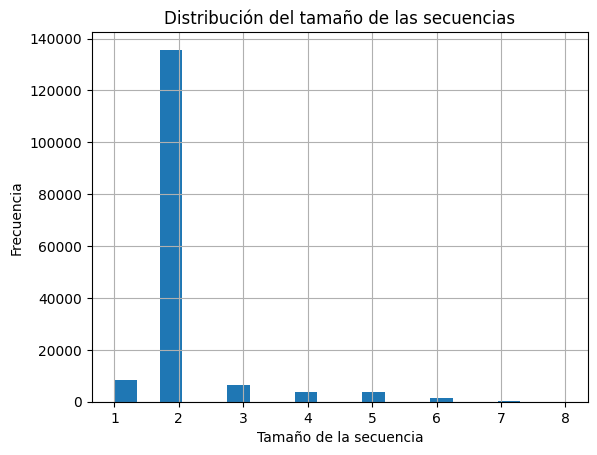

In [94]:
train['seq_len'] = train['sequencia'].apply(len)
train['seq_len'].hist(bins=20)
plt.xlabel('Tamaño de la secuencia')
plt.ylabel('Frecuencia')
plt.title('Distribución del tamaño de las secuencias')
plt.show()



- O gráfico apresenta quantos comentários possuem cada tamanho de sequência.
- **A maioria absoluta está concentrada no tamanho 2**, o que significa que esses comentários contêm apenas informações de comprimento e legibilidade, sem nenhuma toxicidade.
- À medida que o tamanho aumenta, há menos exemplos, pois são casos em que o comentário foi classificado como tóxico em uma ou várias categorias.
- Esse comportamento reforça que o dataset é fortemente desbalanceado, com poucos comentários realmente tóxicos e muitos comentários neutros.

---


#### **b) Mineração de padrões com PrefixSpan**

Esta etapa analisa as sequências categóricas associadas a cada comentário **`(como “curto”, “padrão”, “tóxico”, “insult”, etc.)`** e procura subseqüências que se repetem frequentemente em diferentes comentários. O algoritmo **`PrefixSpan`**, especializado em mineração de padrões sequenciais, é usado para encontrar essas combinações comuns sem gerar todos os candidatos.

In [95]:
from prefixspan import PrefixSpan

# Preparar las secuencias
sequencias = train['sequencia'].tolist()

# Crear el minerador
ps = PrefixSpan(sequencias)

# Soporte mínimo 0.5%
suporte = 0.005
suporte_minimo = int(suporte * len(sequencias))

# Obtener todos los patrones
padroes = ps.frequent(suporte_minimo, closed=True)

# Convertir a DataFrame
df_padroes = pd.DataFrame([
    {
        "sequencia": ", ".join(seq),
        "tamanho": len(seq),
        "suporte_absoluto": suporte,
        "suporte_relativo": suporte / len(sequencias)
    }
    for suporte, seq in padroes
])

# Filtrar patrones con tamaño mínimo 2
df_padroes = df_padroes[df_padroes["tamanho"] >= 3]

# Filtrar patrones que contengan al menos una etiqueta de toxicidad
tox_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
regex = "|".join(tox_labels)
df_padroes = df_padroes[df_padroes["sequencia"].str.contains(regex)]

# Ordenar por suporte
df_padroes = df_padroes.sort_values(by="suporte_absoluto", ascending=False)

# Mostrar top 20
print(df_padroes.head(20))


                                sequencia  tamanho  suporte_absoluto  \
87                 toxic, obscene, insult        3              5954   
69            muito_curto, toxic, obscene        3              2555   
33                  curto, toxic, obscene        3              2387   
35                   curto, toxic, insult        3              2280   
71             muito_curto, toxic, insult        3              2255   
73           muito_curto, obscene, insult        3              1918   
70    muito_curto, toxic, obscene, insult        4              1889   
37                 curto, obscene, insult        3              1864   
34          curto, toxic, obscene, insult        4              1820   
116                 facil, toxic, obscene        3              1525   
43    razoavelmente fácil, toxic, obscene        3              1523   
8                   medio, toxic, obscene        3              1517   
83           toxic, severe_toxic, obscene        3              

- O padrão mais forte com conteúdo tóxico é: “tóxico, obsceno, insulto”, com um **`suporte de 3,73%`** do conjunto de dados.

- Aparecem padrões mixtos entre características textuais (curto, médio, fácil, etc.) e etiquetas tóxicas (tóxic, insult, etc.).

- Os comentários muito curtos e curtos com conteúdo ofensivo **`têm alta frequência`**.

- Também se destaca o aparecimento de combinações com severe_toxic, embora em menor quantidade.

---

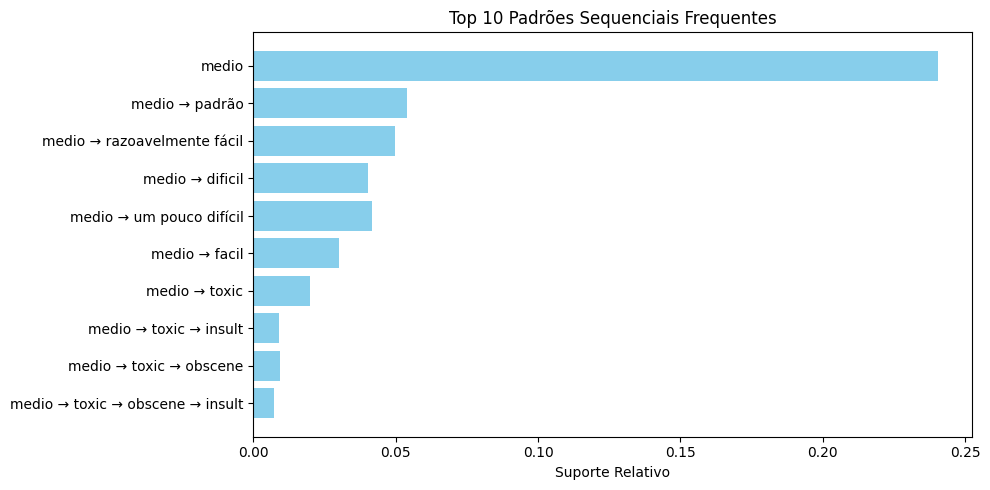

In [96]:
top_10 = padroes[:10]
labels = [' → '.join(seq) for _, seq in top_10]
supports = [s / len(sequencias) for s, _ in top_10]

plt.figure(figsize=(10, 5))
plt.barh(labels[::-1], supports[::-1], color='skyblue')
plt.xlabel('Suporte Relativo')
plt.title('Top 10 Padrões Sequenciais Frequentes')
plt.tight_layout()
plt.show()

- Comentários de tamanho **`médio são muito comuns`**.

- Comentários de tamanho **`médio com legibilidade padrão`**.

- Comentários de tamanho **`médio que são razoavelmente fáceis de ler`**.

- Comentários de tamanho **`médio que são classificados como tóxicos`**.

- Comentários de tamanho **`médio com conteúdo tóxico, obsceno ou ofensivo`**.

In [97]:
# Preparar las secuencias
sequencias = train['sequencia'].tolist()

# Crear el minerador
ps = PrefixSpan(sequencias)

# Soporte mínimo 0.1%
suporte = 0.001
suporte_minimo = int(suporte * len(sequencias))

# Obtener todos los patrones
padroes = ps.frequent(suporte_minimo, closed=True)

# Convertir a DataFrame
df_padroes = pd.DataFrame([
    {
        "sequencia": ", ".join(seq),
        "tamanho": len(seq),
        "suporte_absoluto": suporte,
        "suporte_relativo": suporte / len(sequencias)
    }
    for suporte, seq in padroes
])

# Filtrar patrones con tamaño mínimo 2
df_padroes = df_padroes[df_padroes["tamanho"] >= 2]

# Filtrar patrones que contengan al menos una etiqueta de toxicidad
tox_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
regex = "|".join(tox_labels)
df_padroes = df_padroes[df_padroes["sequencia"].str.contains(regex)]

# Ordenar por suporte
df_padroes = df_padroes.sort_values(by="suporte_absoluto", ascending=False)

# Mostrar top 20
print(df_padroes.head(20))


                       sequencia  tamanho  suporte_absoluto  suporte_relativo
271               toxic, obscene        2              7926          0.049699
277                toxic, insult        2              7343          0.046044
283              obscene, insult        2              6155          0.038594
272       toxic, obscene, insult        3              5954          0.037334
118                 curto, toxic        2              4587          0.028762
216           muito_curto, toxic        2              4134          0.025922
33                  medio, toxic        2              3188          0.019990
143   razoavelmente fácil, toxic        2              3053          0.019144
335                 facil, toxic        2              2732          0.017131
228         muito_curto, obscene        2              2617          0.016410
221  muito_curto, toxic, obscene        3              2555          0.016021
131               curto, obscene        2              2489     

##### **Comentario:**

- Há uma **correlação forte entre os rótulos de toxicidade** (`toxic`, `obscene`, `insult`), o que pode ajudar no desenvolvimento de modelos de classificação mais robustos.

- O **comprimento do comentário** (como `medio`, `curto`, `muito_curto`) influencia bastante os padrões detectados.

- Algumas **combinações de rótulos tóxicos** aparecem com suporte acima de 3%, indicando **alta coocorrência** e potenciais casos de maior severidade.

---


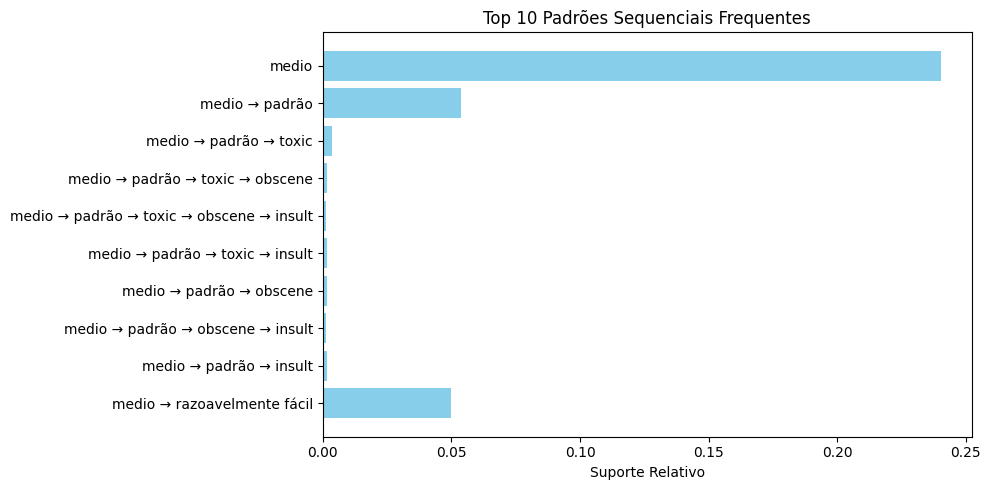

In [98]:
top_10 = padroes[:10]
labels = [' → '.join(seq) for _, seq in top_10]
supports = [s / len(sequencias) for s, _ in top_10]

plt.figure(figsize=(10, 5))
plt.barh(labels[::-1], supports[::-1], color='skyblue')
plt.xlabel('Suporte Relativo')
plt.title('Top 10 Padrões Sequenciais Frequentes')
plt.tight_layout()
plt.show()

##### **Comentario:**

- **`medio`**
   - É o padrão mais frequente (~24% de suporte relativo).
   - Indica que comentários de comprimento médio são os mais comuns.

- **`medio → padrão`**
   - Padrão frequente (~5%).
   - Indica uma transição entre comentários de comprimento médio para uma categoria `padrão`.

- **Sequências envolvendo rótulos tóxicos (`toxic`, `obscene`, `insult`) aparecem com baixo suporte**
   - Isso ocorre porque o gráfico mostra apenas os **10 padrões mais frequentes**, e estes são dominados por aspectos de comprimento do texto.

- **`medio → razoavelmente fácil`**
   - Aparece com ~5% de suporte.
   - Sugere que muitos comentários de comprimento médio também foram classificados como de compreensão razoavelmente fácil.

---